<a href="https://colab.research.google.com/github/ishapugalia/Abstractive-Text-Summarization/blob/main/model_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [297]:
!pip install keras==2.4.3
!pip install tensorflow==2.4.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [298]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [299]:
import numpy as np
import os
import pandas as pd
import re

In [300]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [301]:
import tensorflow as tf
tf.__version__

'2.4.1'

#LOAD DATASET

In [302]:
data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Dataset csv/train.csv")


In [303]:
d_articles=pd.DataFrame(data.iloc[:10000,[0,1]])
print(d_articles[:1])
d_highlights=pd.DataFrame(data.iloc[:10000,[0,2]])
print(d_highlights.columns)
#print(d_articles)

                                         id  \
0  0001d1afc246a7964130f43ae940af6bc6c57f01   

                                             article  
0  By . Associated Press . PUBLISHED: . 14:11 EST...  
Index(['id', 'highlights'], dtype='object')


#DATA PREPROCESSING

In [304]:
num_words = 30000
oov_token = '<UNK>'
pad_type = 'post'
trunc_type = 'post'
MAX_LEN=400
MAX_LEN_S=100

In [305]:
def cleantext(text):
    text = str(text)
    text=text.split()
    words=[]
    for t in text:
        if t.isalpha():
            words.append(t)
    text=" ".join(words)
    text=text.lower()
    text=re.sub(r"what's","what is ",text)
    text=re.sub(r"it's","it is ",text)
    text=re.sub(r"\'ve"," have ",text)
    text=re.sub(r"i'm","i am ",text)
    text=re.sub(r"\'re"," are ",text)
    text=re.sub(r"n't"," not ",text)
    text=re.sub(r"\'d"," would ",text)
    text=re.sub(r"\'s","s",text)
    text=re.sub(r"\'ll"," will ",text)
    text=re.sub(r"can't"," cannot ",text)
    text=re.sub(r" e g "," eg ",text)
    text=re.sub(r"e-mail","email",text)
    text=re.sub(r"9\\/11"," 911 ",text)
    text=re.sub(r" u.s"," american ",text)
    text=re.sub(r" u.n"," united nations ",text)
    text=re.sub(r"\n"," ",text)
    text=re.sub(r":"," ",text)
    text=re.sub(r"-"," ",text)
    text=re.sub(r"\_"," ",text)
    text=re.sub(r"\d+"," ",text)
    text=re.sub(r"[$#@%&*!~?%{}()]"," ",text)
    
    return text

In [306]:
d_articles["article"]= d_articles["article"].apply(lambda x: cleantext(x))

In [307]:
d_highlights["highlights"]= d_highlights["highlights"].apply(lambda x: cleantext(x))

In [308]:
d_highlights["highlights"] = d_highlights["highlights"].apply(lambda x : '_START_ '+ x + ' _END_')

##SPLIT DATASET

In [309]:
from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val=train_test_split(d_articles['article'],d_highlights['highlights'],test_size=0.2,random_state=0,shuffle=True) 

In [310]:
print(x_tr)

7389    by hugo gye january january a closeted gay man...
9275    west bromwich albion have made an improved bid...
2995    defending champions chelsea marched five point...
5316    by daily mail reporter july july european parl...
356     a father has attacked a decision to fine him m...
                              ...                        
9225    barack historic with cuba after years of cold ...
4859    has all the story arcs for including a newly b...
3264    the sister of australian jihadist mohamed elom...
9845    by jack doyle new rights to flexible working w...
2732    paul lambert had just finished holding court w...
Name: article, Length: 8000, dtype: object


571.1908 45.0297


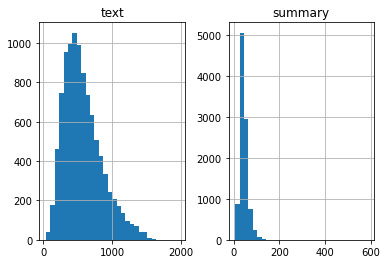

In [311]:
from numpy.lib.function_base import average
import matplotlib.pyplot as plt
text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in d_articles['article']:
      text_word_count.append(len(i.split()))

for i in d_highlights['highlights']:
      summary_word_count.append(len(i.split()))
print(average(text_word_count),average(summary_word_count))
length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})
length_df.hist(bins = 30)
plt.show()

##TOKENIZE AND CREATE WORDtoID DICTIONARY

In [312]:
VOCAB_SIZE = 29999
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(x_tr))
article_sequences = x_tokenizer.texts_to_sequences(x_tr)
test_article=x_tokenizer.texts_to_sequences(x_val)
art_word_index = x_tokenizer.word_index


In [313]:
print(len(art_word_index))

68886


In [314]:
d_highlights.highlights[0]

'_START_ bishop john of north is taking time off after being diagnosed he contracted the infection through contaminated food in italy church members in grand forks and jamestown could have been exposed _END_'

In [315]:
art_vocab = {}
counter = 0
for word in art_word_index.keys():
    if art_word_index[word] == 0:
        print("found 0!")
        break
    if art_word_index[word] > VOCAB_SIZE:
        continue
    else:
        art_vocab[word] = art_word_index[word]
        counter += 1

In [316]:
y_tokenizer=Tokenizer()

y_tokenizer.fit_on_texts(list(y_tr))
summary_sequences = y_tokenizer.texts_to_sequences(y_tr)
test_summary=y_tokenizer.texts_to_sequences(y_val)
sum_word_index = y_tokenizer.word_index
x_voc=len(x_tokenizer.word_index)+1
y_voc=len(y_tokenizer.word_index)+1
print(sum_word_index)
print(art_word_index)

{'the': 1, 'to': 2, 'in': 3, 'end': 4, 'start': 5, 'of': 6, 'a': 7, 'and': 8, 'for': 9, 'was': 10, 'on': 11, 'is': 12, 'he': 13, 'with': 14, 'at': 15, 'his': 16, 'has': 17, 'from': 18, 'by': 19, 'says': 20, 'as': 21, 'her': 22, 'after': 23, 'have': 24, 'be': 25, 'it': 26, 'she': 27, 'are': 28, 'will': 29, 'that': 30, 'been': 31, 'were': 32, 'but': 33, 'an': 34, 'had': 35, 'said': 36, 'they': 37, 'their': 38, 'not': 39, 'new': 40, 'one': 41, 'police': 42, 'who': 43, 'more': 44, 'two': 45, 'out': 46, 'up': 47, 'also': 48, 'over': 49, 'when': 50, 'first': 51, 'found': 52, 'last': 53, 'than': 54, 'this': 55, 'say': 56, 'about': 57, 'him': 58, 'years': 59, 'into': 60, 'now': 61, 'people': 62, 'could': 63, 'home': 64, 'three': 65, 'being': 66, 'before': 67, 'year': 68, 'or': 69, 'world': 70, 'can': 71, 'against': 72, 'no': 73, 'its': 74, 'would': 75, 'former': 76, 'all': 77, 'off': 78, 'just': 79, 'family': 80, 'since': 81, 'back': 82, 'during': 83, 'time': 84, 'some': 85, 'only': 86, 'man':

In [317]:
sum_vocab = {}
counter = 0
for word in sum_word_index.keys():
    if sum_word_index[word] == 0:
        print("found 0!")
        break
    if sum_word_index[word] > VOCAB_SIZE:
        continue
    else:
        sum_vocab[word] = sum_word_index[word]
        counter += 1


##PAD ARTICLES AND SUMMARIES

In [318]:
MAX_LEN = 400
pad_article = pad_sequences(article_sequences, maxlen=MAX_LEN, padding='post', truncating='post')
pad_article_test = pad_sequences(test_article, maxlen=MAX_LEN, padding='post', truncating='post')

In [319]:
MAX_LEN_S= 100
pad_highlight = pad_sequences(summary_sequences, maxlen=MAX_LEN_S, padding='post', truncating='post')
pad_highlight_test = pad_sequences(test_summary, maxlen=MAX_LEN_S, padding='post', truncating='post')

In [320]:
print(pad_article.shape)
print(pad_highlight)
print(pad_highlight_test)

(8000, 400)
[[   5 2372  864 ...    0    0    0]
 [   5 3145   35 ...    0    0    0]
 [   5  335  313 ...    0    0    0]
 ...
 [   5   43   17 ...    0    0    0]
 [   5  392    3 ...    0    0    0]
 [   5 2577 1625 ...    0    0    0]]
[[   5 5691   12 ...    0    0    0]
 [   5  906 4767 ...    0    0    0]
 [   5 1924   15 ...    0    0    0]
 ...
 [   5   85  392 ...    0    0    0]
 [   5  886   57 ...    0    0    0]
 [   5 2618 1344 ...    0    0    0]]


##LOAD PRETRAINED EMBEDDINGS OF 200D

In [321]:
embeddings_index = {}
with open('/content/drive/MyDrive/Colab Notebooks/glove.6B.200d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    f.close()


In [322]:
all_embeddings = np.array(embeddings_index)
np.save('embeddings.npy', all_embeddings)

##INITIALIZE WORD EMBEDDINGS 

In [323]:
def embedding_matrix_creater(embedding_dimension, word_index):
    embedding_matrix = np.zeros((len(word_index) + 1, embedding_dimension))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
          # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector
    return embedding_matrix

In [324]:
art_embedding_matrix = embedding_matrix_creater(200, word_index=art_word_index)
doc_emb=np.zeros((8000,400,200))
for i in range(8000):
  doc_emb[i]=[art_embedding_matrix[j] for j in pad_article[i]]
print(art_word_index)

{'the': 1, 'to': 2, 'a': 3, 'and': 4, 'of': 5, 'in': 6, 'was': 7, 'for': 8, 'that': 9, 'on': 10, 'is': 11, 'he': 12, 'with': 13, 'his': 14, 'as': 15, 'at': 16, 'it': 17, 'by': 18, 'have': 19, 'from': 20, 'has': 21, 'be': 22, 'her': 23, 'but': 24, 'are': 25, 'said': 26, 'an': 27, 'she': 28, 'they': 29, 'who': 30, 'had': 31, 'not': 32, 'i': 33, 'been': 34, 'their': 35, 'were': 36, 'this': 37, 'after': 38, 'will': 39, 'which': 40, 'when': 41, 'one': 42, 'about': 43, 'we': 44, 'more': 45, 'or': 46, 'up': 47, 'out': 48, 'would': 49, 'also': 50, 'you': 51, 'new': 52, 'two': 53, 'all': 54, 'into': 55, 'people': 56, 'can': 57, 'last': 58, 'than': 59, 'told': 60, 'just': 61, 'so': 62, 'there': 63, 'over': 64, 'its': 65, 'what': 66, 'mr': 67, 'first': 68, 'police': 69, 'if': 70, 'could': 71, 'him': 72, 'my': 73, 'no': 74, 'being': 75, 'before': 76, 'some': 77, 'other': 78, 'time': 79, 'like': 80, 'because': 81, 'where': 82, 'while': 83, 'them': 84, 'now': 85, 'down': 86, 'only': 87, 'years': 88,

In [325]:
sum_embedding_matrix = embedding_matrix_creater(200, word_index=sum_vocab)
sum_emb=np.zeros((8000,100,200))
for i in range(8000):
  sum_emb[i]=[sum_embedding_matrix[j] for j in pad_highlight[i]]

In [326]:
# df=pd.DataFrame(art_embedding_matrix)
# df.to_excel("/content/drive/MyDrive/Colab Notebooks/trained/art_embedding_matrix.xlsx")
print(doc_emb)
x_tr_emb,x_val_emb,y_tr_emb,y_val_emb=train_test_split(doc_emb,sum_emb,test_size=0.1,random_state=0,shuffle=True) 

[[[-0.57381999  0.079024   -0.055426   ...  0.30199999 -0.018419
    0.14293   ]
  [-0.75187999  0.51479    -0.53631002 ... -0.083235    0.48541999
    0.50058001]
  [ 0.65319002 -0.016305    1.08920002 ... -0.099537    0.0090426
   -0.44233   ]
  ...
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]]

 [[ 0.28617001  0.016621   -0.041747   ...  0.63128    -0.47112
    0.71089   ]
  [-0.46834001 -0.099371   -0.23082    ...  0.54034001 -0.51670998
    0.30044001]
  [-0.56781     0.39811999 -0.46096    ...  0.2696     -0.38876
    0.67487001]
  ...
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]]

 [[-0.48749     0.4833     -0.15978999 ... -0

##SAVE THE EMBEDDINGS

In [327]:
# import pickle
# filehandler = open("/content/drive/MyDrive/Colab Notebooks/trained/art_vocab", 'wb')
# pickle.dump(art_vocab, filehandler)

In [328]:
# filehandler = open("/content/drive/MyDrive/Colab Notebooks/trained/doc_emb", 'wb')
# pickle.dump(doc_emb, filehandler,protocol=4)

In [329]:
#file = open('/content/drive/MyDrive/Colab Notebooks/trained/art_vocab.txt', 'rb')

#dump information to that file
#data1 = pickle.load(file)
#print(data1)

In [330]:
def embedding_layer_creater(VOCAB_SIZE, EMBEDDING_DIM, MAX_LEN, embedding_matrix):
  embedding_layer = tf.keras.layers.Embedding(input_dim = VOCAB_SIZE, 
                                    output_dim = EMBEDDING_DIM,
                                    input_length = MAX_LEN,
                                    weights = [embedding_matrix],
                                    trainable = False)
  
  return embedding_layer



In [331]:
if not os.path.exists("/content/drive/MyDrive/Colab Notebooks/trained"):
    os.makedirs("/content/drive/MyDrive/Colab Notebooks/trained")

In [332]:
!pip install chart-studio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#BUILD MODEL

In [333]:
from numpy.random import seed
seed(1)
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
import warnings
import tensorflow as tf
from sklearn.model_selection import train_test_split
import logging

import plotly.graph_objs as go
import matplotlib.pyplot as plt
import pandas as pd
import pydot
import keras
import numpy as np
from keras import backend as K
K.set_learning_phase(1)
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras import initializers
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping
from keras.layers.advanced_activations import LeakyReLU,PReLU
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.python.keras.layers import Layer

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:434: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


In [334]:
#Hyperparams
#LSTM ENCODER
MAX_LEN = 400
MAX_LEN_S=100
VOCAB_SIZE=30000
EMBEDDING_DIM = 200
HIDDEN_UNITS = 256
#VOCAB_SIZE = VOCAB_SIZE + 1
LEARNING_RATE = 0.002
K.clear_session()
input_len=MAX_LEN
# model=Sequential()
# l1 = embedding_layer_creater(VOCAB_SIZE, EMBEDDING_DIM, MAX_LEN, art_embedding_matrix)
# model.add(l1)
# model.add(Bidirectional(LSTM(units=HIDDEN_UNITS,return_sequences=True)))
# #model.add(LSTM(units=HIDDEN_UNITS,return_sequences=True))
# #model.add(Dense(units=VOCAB_SIZE))
# #model.add(Activation('softmax'))
# model.compile(optimizer='adam', loss='sparse_crossentropy')
# #model.build((None,400,200))
# #Encoder

# #input_l1=Input(shape=(input_len,200))
# #all_state_h=LSTM(HIDDEN_UNITS,return_sequences=True)(input_l1)
# #model=Model(input_l1,outputs=all_state_h)

# print(model.summary())


In [335]:
from tensorflow.python.keras.layers import Layer
from tensorflow.python.keras import backend as K


class AttentionLayer(Layer):
    """
    This class implements Bahdanau attention (https://arxiv.org/pdf/1409.0473.pdf).
    There are three sets of weights introduced W_a, U_a, and V_a
     """

    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert isinstance(input_shape, list)
        # Create a trainable weight variable for this layer.

        self.W_a = self.add_weight(name='W_a',
                                   shape=tf.TensorShape((input_shape[0][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.U_a = self.add_weight(name='U_a',
                                   shape=tf.TensorShape((input_shape[1][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.V_a = self.add_weight(name='V_a',
                                   shape=tf.TensorShape((input_shape[0][2], 1)),
                                   initializer='uniform',
                                   trainable=True)

        super(AttentionLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, inputs, verbose=False):
        """
        inputs: [encoder_output_sequence, decoder_output_sequence]
        """
        assert type(inputs) == list
        encoder_out_seq, decoder_out_seq = inputs
        if verbose:
            print('encoder_out_seq>', encoder_out_seq.shape)
            print('decoder_out_seq>', decoder_out_seq.shape)

        def energy_step(inputs, states):
            """ Step function for computing energy for a single decoder state """

            assert_msg = "States must be a list. However states {} is of type {}".format(states, type(states))
            assert isinstance(states, list) or isinstance(states, tuple), assert_msg

            """ Some parameters required for shaping tensors"""
            en_seq_len, en_hidden = encoder_out_seq.shape[1], encoder_out_seq.shape[2]
            de_hidden = inputs.shape[-1]

            """ Computing S.Wa where S=[s0, s1, ..., si]"""
            # <= batch_size*en_seq_len, latent_dim
            reshaped_enc_outputs = K.reshape(encoder_out_seq, (-1, en_hidden))
            # <= batch_size*en_seq_len, latent_dim
            W_a_dot_s = K.reshape(K.dot(reshaped_enc_outputs, self.W_a), (-1, en_seq_len, en_hidden))
            if verbose:
                print('wa.s>',W_a_dot_s.shape)

            """ Computing hj.Ua """
            U_a_dot_h = K.expand_dims(K.dot(inputs, self.U_a), 1)  # <= batch_size, 1, latent_dim
            if verbose:
                print('Ua.h>',U_a_dot_h.shape)

            """ tanh(S.Wa + hj.Ua) """
            # <= batch_size*en_seq_len, latent_dim
            reshaped_Ws_plus_Uh = K.tanh(K.reshape(W_a_dot_s + U_a_dot_h, (-1, en_hidden)))
            if verbose:
                print('Ws+Uh>', reshaped_Ws_plus_Uh.shape)

            """ softmax(va.tanh(S.Wa + hj.Ua)) """
            # <= batch_size, en_seq_len
            e_i = K.reshape(K.dot(reshaped_Ws_plus_Uh, self.V_a), (-1, en_seq_len))
            # <= batch_size, en_seq_len
            e_i = K.softmax(e_i)

            if verbose:
                print('ei>', e_i.shape)

            return e_i, [e_i]

        def context_step(inputs, states):
            """ Step function for computing ci using ei """
            # <= batch_size, hidden_size
            c_i = K.sum(encoder_out_seq * K.expand_dims(inputs, -1), axis=1)
            if verbose:
                print('ci>', c_i.shape)
            return c_i, [c_i]

        def create_inital_state(inputs, hidden_size):
            # We are not using initial states, but need to pass something to K.rnn funciton
            fake_state = K.zeros_like(inputs)  # <= (batch_size, enc_seq_len, latent_dim
            fake_state = K.sum(fake_state, axis=[1, 2])  # <= (batch_size)
            fake_state = K.expand_dims(fake_state)  # <= (batch_size, 1)
            fake_state = K.tile(fake_state, [1, hidden_size])  # <= (batch_size, latent_dim
            return fake_state

        fake_state_c = create_inital_state(encoder_out_seq, encoder_out_seq.shape[-1])
        fake_state_e = create_inital_state(encoder_out_seq, encoder_out_seq.shape[1])  # <= (batch_size, enc_seq_len, latent_dim

        """ Computing energy outputs """
        # e_outputs => (batch_size, de_seq_len, en_seq_len)
        last_out, e_outputs, _ = K.rnn(
            energy_step, decoder_out_seq, [fake_state_e],
        )

        """ Computing context vectors """
        last_out, c_outputs, _ = K.rnn(
            context_step, e_outputs, [fake_state_c],
        )

        return c_outputs, e_outputs
    def get_config(self):
      config = super(AttentionLayer, self).get_config()
      
      return config

    def compute_output_shape(self, input_shape):
        """ Outputs produced by the layer """
        return [
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[1][2])),
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[0][1]))
        ]


In [336]:
import tensorflow as tf

tf.__version__

'2.4.1'

In [352]:
from keras import backend as K 
K.clear_session() 
latent_dim = 256

max_len_text=400
max_len_summary=100
# Encoder 
encoder_inputs = Input(shape=(max_len_text,)) 
enc_emb = Embedding(x_voc, 200, weights=[art_embedding_matrix],input_length=max_len_text, trainable=False)(encoder_inputs) 

#LSTM 1 
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True) 
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb) 

#LSTM 2 
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True) 
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1) 

#LSTM 3 
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True) 
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2) 

# Set up the decoder. 
decoder_inputs = Input(shape=(None,)) 
dec_emb_layer = Embedding(x_voc, 200, weights=[art_embedding_matrix],input_length=max_len_text, trainable=False) 

dec_emb = dec_emb_layer(decoder_inputs) 

#LSTM using encoder_states as initial state
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True) 
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c]) 

#Attention Layer
attn_layer = AttentionLayer(name='attention_layer') 
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs]) 

# Concat attention output and decoder LSTM output 
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#Dense layer
decoder_dense = TimeDistributed(Dense(y_voc, activation='softmax')) 
decoder_outputs = decoder_dense(decoder_concat_input) 

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs) 
config = model.get_config()
print(config)
# At loading time, register the custom objects with a `custom_object_scope`:
custom_objects = {"AttentionLayer": AttentionLayer}
with keras.utils.custom_object_scope(custom_objects):
    new_model = keras.Model.from_config(config)
with keras.utils.custom_object_scope(custom_objects):
    new_model = keras.models.clone_model(model)
model.summary()

{'name': 'model', 'layers': [{'class_name': 'InputLayer', 'config': {'batch_input_shape': (None, 400), 'dtype': 'float32', 'sparse': False, 'ragged': False, 'name': 'input_1'}, 'name': 'input_1', 'inbound_nodes': []}, {'class_name': 'Embedding', 'config': {'name': 'embedding', 'trainable': False, 'batch_input_shape': (None, 400), 'dtype': 'float32', 'input_dim': 68887, 'output_dim': 200, 'embeddings_initializer': {'class_name': 'RandomUniform', 'config': {'minval': -0.05, 'maxval': 0.05, 'seed': None}}, 'embeddings_regularizer': None, 'activity_regularizer': None, 'embeddings_constraint': None, 'mask_zero': False, 'input_length': 400}, 'name': 'embedding', 'inbound_nodes': [[['input_1', 0, 0, {}]]]}, {'class_name': 'LSTM', 'config': {'name': 'lstm', 'trainable': True, 'dtype': 'float32', 'return_sequences': True, 'return_state': True, 'go_backwards': False, 'stateful': False, 'unroll': False, 'time_major': False, 'units': 256, 'activation': 'tanh', 'recurrent_activation': 'sigmoid', 'u

In [353]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

In [354]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=1)

In [356]:
history=model.fit([pad_article,pad_highlight[:,:-1]], pad_highlight.reshape(pad_highlight.shape[0],pad_highlight.shape[1], 1)[:,1:] ,epochs=30,callbacks=[es],batch_size=32, validation_data=([pad_article_test,pad_highlight_test[:,:-1]], pad_highlight_test.reshape(pad_highlight_test.shape[0],pad_highlight_test.shape[1], 1)[:,1:]))

Epoch 1/30
250/250 [==============================] - 106s 399ms/step - loss: 3.4493 - val_loss: 3.0142
Epoch 2/30
250/250 [==============================] - 98s 392ms/step - loss: 3.1555 - val_loss: 2.9304
Epoch 3/30
250/250 [==============================] - 98s 392ms/step - loss: 3.0437 - val_loss: 2.8468
Epoch 4/30
250/250 [==============================] - 98s 392ms/step - loss: 2.9693 - val_loss: 2.8084
Epoch 5/30
250/250 [==============================] - 98s 392ms/step - loss: 2.9034 - val_loss: 2.7824
Epoch 6/30
250/250 [==============================] - 98s 392ms/step - loss: 2.8439 - val_loss: 2.7606
Epoch 7/30
250/250 [==============================] - 98s 392ms/step - loss: 2.7876 - val_loss: 2.7511
Epoch 8/30
250/250 [==============================] - 98s 392ms/step - loss: 2.7347 - val_loss: 2.7398
Epoch 9/30
250/250 [==============================] - 98s 392ms/step - loss: 2.6841 - val_loss: 2.7406
Epoch 00009: early stopping


In [363]:
from keras.models import load_model
model.save("/content/drive/MyDrive/Colab Notebooks/trained/model_2")


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/trained/model_2/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/trained/model_2/assets


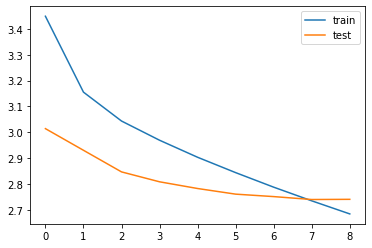

In [357]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [358]:
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index

In [359]:
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(MAX_LEN,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs) 
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat) 

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [367]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['start']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        
        if(sampled_token!='start'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'end'  or len(decoded_sentence.split()) >= (MAX_LEN_S-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [360]:
len(target_word_index)

26387

In [368]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['start']) and i!=target_word_index['end']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

In [394]:
predicted=pd.DataFrame(columns=['original','output'])
for i in range(0,10):
    print("Article:",x_val.iloc[i])
    print("Original summary:",y_val.iloc[i])
    print("Predicted summary:",decode_sequence(pad_article_test[i].reshape(1,MAX_LEN)))
    print("\n")
    
    data=[y_val.iloc[i],' '.join(decode_sequence(pad_article_test[i].reshape(1, max_len_text)).split())]
    predicted=pd.concat([predicted,pd.DataFrame([data],columns=predicted.columns)],ignore_index=True)

Article: rosetta mission is currently making its way towards a comet in the solar in a series of stunning new it reveals how comet has begun to develop into an exciting ball of dust and over a period of six weeks the comet has begun to extend its dusty veil known as a into this sequence of images was taken between march and as the gap between spacecraft and comet closed from around million miles million to million miles million the rosetta spacecraft is set to rendezvous with the comet later this month before entering orbit in august and becoming the first spacecraft ever to orbit a named after a block of stone that helped archeologists decipher ancient egyptian will seek to help scientists unlock the composition of comets and thereby understand more about the origins and evolution of our solar the probe was launched in and has since travelled around the sun five picking up energy from earth and mars to line it up with its final comet for the loneliest leg of the as rosetta travelled o

In [395]:
predicted.to_csv("/content/drive/MyDrive/Colab Notebooks/trained/predicted.csv")

In [375]:
!pip install rouge
from rouge import Rouge
ROUGE = Rouge()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [397]:
candidate,reference=predicted['output'],predicted['original']
#for i in range(len(candidate)):
 #candidate[i]=" ".join(el for el in candidate[i])
print(ROUGE.get_scores(candidate, reference,avg=True))
predicted

{'rouge-1': {'r': 0.1291120866373955, 'p': 0.2849381827323004, 'f': 0.1732375197644099}, 'rouge-2': {'r': 0.02054135803788258, 'p': 0.04070459496930086, 'f': 0.026197180157393817}, 'rouge-l': {'r': 0.10113932712740195, 'p': 0.2202730439495145, 'f': 0.13477590234686956}}


,original,output
0,_START_ rosetta spacecraft is getting ready to...,the images of the images of the first time the...
1,_START_ join sandy halperin from to et on tues...,the former was born in the new york he was a g...
2,_START_ pupils at the army public school can b...,the men is a man of the men of the men of the ...
3,_START_ microsoft announced it is buying mobil...,the app is a big of the new york in the world ...
4,_START_ manny pacquiao will fight puerto migue...,the world champion of the world cup champion i...
5,_START_ warning graphic han has had the massiv...,doctors was born in a hospital in hospital aft...
6,_START_ great expectations was watched by six ...,the new york is the first time in the new york...
7,_START_ author died peacefully at her london h...,former was a former of her husband in the last...
8,_START_ rhys thomas having transplant on tuesd...,the world cup is a brain injury for the first ...
9,_START_ danny purdy saved up of his own money ...,the woman was found dead in the last year in t...


#KNOWLEDGE BASE EMBEDDINGS

In [ ]:
import pandas
entity_file= pandas.read_csv('/content/drive/MyDrive/Colab Notebooks/Dataset csv/entity_embeddings.tsv',sep='\t',header=None)
entity_file[:].shape

In [ ]:
X=entity_file.iloc[:,0]
Y=entity_file.iloc[:,1:201]

In [ ]:
doc_emb[0]

##VISUALIZE KB AND DATASET EMBEDDINGS

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.decomposition import PCA as sklearnPCA
pca = sklearnPCA(n_components=2) #2-dimensional PCA
transformed = pd.DataFrame(pca.fit_transform(Y))
plt.scatter(transformed[:20][0], transformed[:20][1],c='red')
t=pd.DataFrame(pca.fit_transform(doc_emb[0]))
plt.scatter(t[:10][0], t[:10][1],c='blue')
word_list=list(art_word_index.keys())
for i in range(10):
  plt.annotate(str(word_list[pad_article[0][i]-1])+str(i),(t[0][i],t[1][i]))
for i in range(20):
  plt.annotate(str(X[i]),(transformed[0][i],transformed[1][i]))
plt.xlim(-1,1)
plt.show()

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity 
import numpy as np

def similar_documents(text, df, n=5):
    df=pd.DataFrame(columns=['text','entity','similarity'])
    for doc in text:
      arr=cosine_similarity(doc,Y)
      arr = -np.sort(-arr, axis=1)[:,5]
      data=[]
    #return (df.sort_values(by='similarity', ascending=False)[['text', 'similarity']].head(n))
      pd.concat()
    return arr[:,:5]

#user_input = """Nah I don't think he goes to usf, he lives around here though"""

similar_documents(doc_emb, Y, 5).shape
print(similar_documents(doc_emb[0], Y, 5))